In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf  # Example: using yfinance to fetch historical data
import matplotlib.pyplot as plt


""" ----------------------------------INPUTS----------------------------------------- """
""" THIS WINDOW CONTAINS THE ONLY INPUTS NEEDED FOR THIS MODEL TO OPERATE AS INTENDED """

""" i'll be cleaning up the rest of this so that you can easily copy and paste it into new
    files for now if you want to run multiple of these analysis together at the same time
    and compare them, i will work on building an app for this so that we can easily go
    to a website and feed it the inputs and it gives us what this gives us but with more details """

# Set pre-chosen set of ETF tickers in the list below
etfs = ["SPYG", "VTV", "VBK", "VBR", "IJH", "EFA", "EEM", "AGG", "LQD", "HYG", "VNQ", "GLD"]

# Set start and end dates for the historical performance data query (used for correlations, covariance, and standard deviation)
fetch_start_date = "2020-02-02"
fetch_end_date = "2025-02-02"

# Set expected returns of each ETF (we will automate this next)
expected_returns = np.array([0.12, 0.10, 0.12, 0.11, 0.125, 0.08, 0.09, 0.05, 0.06, 0.07, 0.10, 0.04])

# Set number of random portfolios to simulate
n_portfolios = 10000

# Set risk free rate to be used for sharpe ratio calculation
risk_free_rate = .03


In [ ]:
""" DOWNLOAD DATA, SETUP DATA """

# Download historical price data - extract closing prices
price_data = yf.download(etfs, start=fetch_start_date, end=fetch_end_date)
price_data = price_data["Close"]

# Calculate daily returns using percentage change
returns = price_data.pct_change().dropna()

[*********************100%***********************]  3 of 3 completed


Experiment #1: A basket of diversified assets (Domestic Equities, International Equities, Fixed Income, Alternative Assets)

In [ ]:
""" DOWNLOAD DATA, SETUP DATA """

# Download historical price data - extract closing prices
price_data = yf.download(etfs, start=fetch_start_date, end=fetch_end_date)
price_data = price_data["Close"]

# Calculate daily returns using percentage change
returns = price_data.pct_change().dropna()


""" PROBLEM SETUP """

# Compute empirical standard deviations of each ETF's daily returns
empirical_std_devs = returns.std()

# Compute the empirical correlation matrix
empirical_corr_matrix = returns.corr()

# Compute the covariance matrix using empirical standard deviations and the empirical correlation matrix
cov_matrix = np.outer(empirical_std_devs, empirical_std_devs) * empirical_corr_matrix



""" PORTFOLIO WEIGHT PERMUTATIONS """
# Array to store portfolio results
portfolio_returns = [] # stores integers of % return of each simulated portfolio
portfolio_risks = [] # stores integers of return adjusted risk ratios of each simulated portfolio
portfolio_weights = [] # Stores vectors of portfolio weights of each simulated portfolio
sharpe_ratios = [] # stores integers of sharpe ratio values of each simulated portfolio




# -- METHODOLOGY--
# Use 3m equivilant short term rate for funding as risk free rate assumption
# Can be more scientific, we can estimate the yield curve tactically and estimate where future
# 3m equivilant short term rates will be that allow us to fine tune our forward assumptions for risk/performance

# Generate portfolios
for i in range(n_portfolios):

    """CREATE RANDOM PERMUTATION OF ALLOCATION WEIGHTS FROM THE SUBSET OF ETF FUNDS FOR EACH SIMULATED PORTFOLIO"""

    # -- Methodology --
    # This is where we would perform PCA, in order to determine the weights of the correlations respective to each ETF vs the universe
    # Our expected output would be a list of weights (correlations/covariance) representing how much they each impact each other
    # in a d-dimensional subspace where d is the number of etf's to analyze.

    # In practice this is performed with correlations bc correlations capture direction and relationship strength while covariance only captures direction

    # Currently, this is generating a set of random weights of allocation to the available set of etfs above
    # The goal is to generate 10000 permutations of allocation ratios between this subset of 5 etfs

    # Generate random weights and normalize them to sum to 1
    random_weights = np.random.rand(len(etfs))
    normalized_weights = random_weights / np.sum(random_weights)



    # CALCULATE THE PORTFOLIO'S EXPECTED RETURNS AS A FUNCTION OF THE RANDOMLY SELECTED ALLOCATION %'S

    # -- Methodology --
    # performs a matrix multiplication operation between the expected returns vector (multiple numbers) and normalized weights vector (multiple numbers)
    # expected output = integer representing the total % performance of the given portfolio

    # Compute portfolio return
    port_return = np.dot(normalized_weights, expected_returns)


    """CALCULATE PORTFOLIO VARIANCE AND STANDARD DEVIATION"""

    #-- Methodology --
    # performs a matrix multiplication operation between the normalized weights vector (multiple numbers) and the covariance matrix (multiple vectors)

    # We can draw this out, more intuitive that way:
    # Y = np.dot(cov_matrix, normalized_weights) -> outputs a row vector where each element represents the weighted sum of covariances for a particular etf
    # np.dot(normalized_weights.T, Y) -> outputs an integer after combining the intermediate results of Y and the normalized weights vector (transposed so column vector)

    # Compute portfolio std deviation by sqrt variance (variance can be +/-, sqrt normalizes)

    port_variance = np.dot(normalized_weights.T, np.dot(cov_matrix, normalized_weights))
    port_risk = np.sqrt(port_variance)



    """CALCULATE SHARPE RATIO FOR EACH GIVEN SIMULATED PORTFOLIO"""

    #-- Methodology --
    # Simple tool used to measure the return of our portfolio minus guarenteed return (this subset of space represents our edge)
    # relatively to our risk profile

    # Compute Sharpe Ratio
    sharpe_ratio = (port_return - risk_free_rate) / port_risk



    # Store results
    portfolio_returns.append(port_return)
    portfolio_risks.append(port_risk)
    portfolio_weights.append(normalized_weights)
    sharpe_ratios.append(sharpe_ratio)

    print("Portfolio: ", i, "\n")
    print("Expected Returns: ", expected_returns)
    print("Normalized Random Weights: ", normalized_weights)
    print("Portfolio", i, "projected return: ", port_return)
    print("Covariance adjusted portfolio risk: ", port_risk)
    print("Portfolio Variance = ","np.dot(normalized_weights.T, Y) = ", port_variance)
    print("Portfolio Standard Deviation = sqrt(Portfolio variance) = ", port_risk, "\n \n")
    #print("Y = np.dot(cov_matrix, normalized_weights) = ", np.dot(cov_matrix, normalized_weights))
    #print("normalized_weights.T = ", normalized_weights.T)



# Convert to DataFrame
df = pd.DataFrame({
    "Portfolio Return": portfolio_returns,
    "Portfolio Risk": portfolio_risks,
    "Sharpe Ratio": sharpe_ratios
})

# Add ETF weights to the DataFrame
for idx, etf in enumerate(etfs):
    column_values = []
    for weights in portfolio_weights:
        # For each portfolio's weight vector, append the weight corresponding to the current ETF (indexed by idx)
        column_values.append(weights[idx])
    # Assign the list of weights to the corresponding column in the DataFrame
    df[etf] = column_values


# Find the portfolio with the maximum Sharpe Ratio (Tangency Portfolio)
max_sharpe_idx = df["Sharpe Ratio"].idxmax()
max_sharpe_portfolio = df.loc[max_sharpe_idx]

# Find the portfolio with the minimum risk (Minimum Variance Portfolio)
min_variance_idx = df["Portfolio Risk"].idxmin()
min_variance_portfolio = df.loc[min_variance_idx]




Portfolio:  0 

Expected Returns:  [0.12  0.1   0.12  0.11  0.125 0.08  0.09  0.05  0.06  0.07  0.1   0.04 ]
Normalized Random Weights:  [0.05682581 0.108828   0.05046616 0.06525579 0.16274946 0.00689022
 0.12901417 0.03763887 0.16145333 0.07016549 0.00129343 0.14941927]
Portfolio 0 projected return:  0.0860289901473308
Covariance adjusted portfolio risk:  0.009491717641954044
Portfolio Variance =  np.dot(normalized_weights.T, Y) =  9.009270379458165e-05
Portfolio Standard Deviation = sqrt(Portfolio variance) =  0.009491717641954044 
 

Portfolio:  1 

Expected Returns:  [0.12  0.1   0.12  0.11  0.125 0.08  0.09  0.05  0.06  0.07  0.1   0.04 ]
Normalized Random Weights:  [0.07311455 0.13453004 0.09520372 0.01351424 0.13872275 0.11520808
 0.11257659 0.14366405 0.05911382 0.02590688 0.06235049 0.02609479]
Portfolio 1 projected return:  0.09164900014077479
Covariance adjusted portfolio risk:  0.010232704540209156
Portfolio Variance =  np.dot(normalized_weights.T, Y) =  0.00010470824220721

KeyboardInterrupt: 

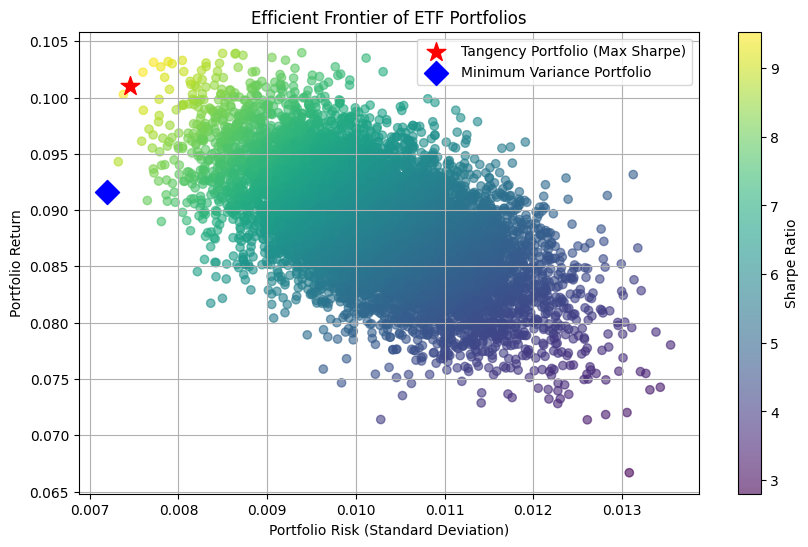

In [ ]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df["Portfolio Risk"], df["Portfolio Return"], c=df["Sharpe Ratio"], cmap='viridis', alpha=0.6)
plt.colorbar(label='Sharpe Ratio')

# Label axes
plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Portfolio Return')
plt.title('Efficient Frontier of ETF Portfolios')
plt.grid(True)

# Highlight the Tangency Portfolio (Max Sharpe Ratio)
plt.scatter(max_sharpe_portfolio["Portfolio Risk"], max_sharpe_portfolio["Portfolio Return"],
            color='red', marker='*', s=200, label='Tangency Portfolio (Max Sharpe)')

# Highlight the Minimum Variance Portfolio
plt.scatter(min_variance_portfolio["Portfolio Risk"], min_variance_portfolio["Portfolio Return"],
            color='blue', marker='D', s=150, label='Minimum Variance Portfolio')

# Add legend
plt.legend()
plt.show()



In [ ]:
print("🔴 Tangency Portfolio (Max Sharpe Ratio):")
print(max_sharpe_portfolio)

print("\n🔵 Minimum Variance Portfolio (Lowest Risk):")
print(min_variance_portfolio)


🔴 Tangency Portfolio (Max Sharpe Ratio):
Portfolio Return    0.101063
Portfolio Risk      0.007458
Sharpe Ratio        9.528128
SPYG                0.165187
VTV                 0.083095
VBK                 0.084633
VBR                 0.144811
IJH                 0.120365
EFA                 0.049487
EEM                 0.163000
AGG                 0.047319
LQD                 0.017900
HYG                 0.021342
VNQ                 0.068716
GLD                 0.034146
Name: 2506, dtype: float64

🔵 Minimum Variance Portfolio (Lowest Risk):
Portfolio Return    0.091573
Portfolio Risk      0.007195
Sharpe Ratio        8.558215
SPYG                0.188447
VTV                 0.015874
VBK                 0.049261
VBR                 0.181840
IJH                 0.027162
EFA                 0.053460
EEM                 0.217544
AGG                 0.105507
LQD                 0.048712
HYG                 0.006690
VNQ                 0.022007
GLD                 0.083495
Name: 3746, dtype

Experimental: partition of the total set (only US equities)

In [ ]:
""" Partition - for experimentation """

etfs = etfs[:5]
expected_returns = expected_returns[:5]
price_data = price_data[etfs]
returns = returns[etfs]



""" PROBLEM SETUP """
# -- TODO --> COMPLETE
# We need historical data to calc standard deviations of returns, needed for extracting covarience/correlation
# once we have historical return performance data, we can extract covariances and standard deviations

# Define standard deviations (risk)
empirical_std_devs = returns.std()


# -- TODO --> COMPLETE
# Calculate covarience matrix from returns performance deviations
# See attached latex file for more insight
# can also be done easily once we have historic data using formulas highlighted in the file listed above

# Build a covariance matrix for the 12 ETFs.
# (In practice, you would compute this using historical return data.)
empirical_corr_matrix = returns.corr()
cov_matrix = np.outer(empirical_std_devs, empirical_std_devs) * empirical_corr_matrix



# -- TERMINOLOGY --
# vector -> imagine a list of numbers like a list of stock prices or a list of names, represents many things in 1 dimension
# Ex: [aaron, odi, sage], [25, 45, 24, 15]

# matrix -> just a vector with many vectors in it if you think about it...
#few ways to imagine it:

#[[aaron, odi, sage],
# [marcos, mercy, manon],
# [bobby, ralphy, maddie]]

#[
# [aaron, odi, sage]
# [marcos, mercy, manon]
# [bobby, ralphy, maddie]
#                        ]



""" OPERATIONS """
# Array to store portfolio results
portfolio_returns = [] # stores integers of % return of each simulated portfolio
portfolio_risks = [] # stores integers of return adjusted risk ratios of each simulated portfolio
portfolio_weights = [] # Stores vectors of portfolio weights of each simulated portfolio
sharpe_ratios = [] # stores integers of sharpe ratio values of each simulated portfolio

# -- METHODOLOGY--
# Use 3m equivilant short term rate for funding as risk free rate assumption
# Can be more scientific, we can estimate the yield curve tactically and estimate where future
# 3m equivilant short term rates will be that allow us to fine tune our forward assumptions for risk/performance

# Generate portfolios
for i in range(n_portfolios):

    """CREATE RANDOM PERMUTATION OF ALLOCATION WEIGHTS FROM THE SUBSET OF ETF FUNDS FOR EACH SIMULATED PORTFOLIO"""

    # -- Methodology --
    # This is where we would perform PCA, in order to determine the weights of the correlations respective to each ETF vs the universe
    # Our expected output would be a list of weights (correlations/covariance) representing how much they each impact each other
    # in a d-dimensional subspace where d is the number of etf's to analyze.

    # In practice this is performed with correlations bc correlations capture direction and relationship strength while covariance only captures direction

    # Currently, this is generating a set of random weights of allocation to the available set of etfs above
    # The goal is to generate 10000 permutations of allocation ratios between this subset of 5 etfs

    # Generate random weights and normalize them to sum to 1
    random_weights = np.random.rand(len(etfs))
    normalized_weights = random_weights / np.sum(random_weights)



    # CALCULATE THE PORTFOLIO'S EXPECTED RETURNS AS A FUNCTION OF THE RANDOMLY SELECTED ALLOCATION %'S

    # -- Methodology --
    # performs a matrix multiplication operation between the expected returns vector (multiple numbers) and normalized weights vector (multiple numbers)
    # expected output = integer representing the total % performance of the given portfolio

    # Compute portfolio return
    port_return = np.dot(normalized_weights, expected_returns)


    """CALCULATE PORTFOLIO VARIANCE AND STANDARD DEVIATION"""

    #-- Methodology --
    # performs a matrix multiplication operation between the normalized weights vector (multiple numbers) and the covariance matrix (multiple vectors)

    # We can draw this out, more intuitive that way:
    # Y = np.dot(cov_matrix, normalized_weights) -> outputs a row vector where each element represents the weighted sum of covariances for a particular etf
    # np.dot(normalized_weights.T, Y) -> outputs an integer after combining the intermediate results of Y and the normalized weights vector (transposed so column vector)

    # Compute portfolio std deviation by sqrt variance (variance can be +/-, sqrt normalizes)

    port_variance = np.dot(normalized_weights.T, np.dot(cov_matrix, normalized_weights))
    port_risk = np.sqrt(port_variance)


    """CALCULATE SHARPE RATIO FOR EACH GIVEN SIMULATED PORTFOLIO"""

    #-- Methodology --
    # Simple tool used to measure the return of our portfolio minus guarenteed return (this subset of space represents our edge)
    # relatively to our risk profile

    # Compute Sharpe Ratio
    sharpe_ratio = (port_return - risk_free_rate) / port_risk



    # Store results
    portfolio_returns.append(port_return)
    portfolio_risks.append(port_risk)
    portfolio_weights.append(normalized_weights)
    sharpe_ratios.append(sharpe_ratio)

    print("Portfolio: ", i, "\n")
    print("Expected Returns: ", expected_returns)
    print("Normalized Random Weights: ", normalized_weights)
    print("Portfolio", i, "projected return: ", port_return)
    print("Covariance adjusted portfolio risk: ", port_risk)
    print("Portfolio Variance = ","np.dot(normalized_weights.T, Y) = ", port_variance)
    print("Portfolio Standard Deviation = sqrt(Portfolio variance) = ", port_risk, "\n \n")
    #print("Y = np.dot(cov_matrix, normalized_weights) = ", np.dot(cov_matrix, normalized_weights))
    #print("normalized_weights.T = ", normalized_weights.T)



# Convert to DataFrame
df = pd.DataFrame({
    "Portfolio Return": portfolio_returns,
    "Portfolio Risk": portfolio_risks,
    "Sharpe Ratio": sharpe_ratios
})

# Add ETF weights to the DataFrame
for idx, etf in enumerate(etfs):
    column_values = []
    for weights in portfolio_weights:
        # For each portfolio's weight vector, append the weight corresponding to the current ETF (indexed by idx)
        column_values.append(weights[idx])
    # Assign the list of weights to the corresponding column in the DataFrame
    df[etf] = column_values


# Find the portfolio with the maximum Sharpe Ratio (Tangency Portfolio)
max_sharpe_idx = df["Sharpe Ratio"].idxmax()
max_sharpe_portfolio = df.loc[max_sharpe_idx]

# Find the portfolio with the minimum risk (Minimum Variance Portfolio)
min_variance_idx = df["Portfolio Risk"].idxmin()
min_variance_portfolio = df.loc[min_variance_idx]


Streaming output truncated to the last 5000 lines.
Portfolio 9500 projected return:  0.11822648953563239
Covariance adjusted portfolio risk:  0.015365958800994006
Portfolio Variance =  np.dot(normalized_weights.T, Y) =  0.00023611268987384513
Portfolio Standard Deviation = sqrt(Portfolio variance) =  0.015365958800994006 
 

Portfolio:  9501 

Expected Returns:  [0.12  0.1   0.12  0.11  0.125]
Normalized Random Weights:  [0.07520523 0.19485654 0.28019689 0.27918196 0.17055939]
Portfolio 9501 projected return:  0.11416384667713449
Covariance adjusted portfolio risk:  0.015015646034241647
Portfolio Variance =  np.dot(normalized_weights.T, Y) =  0.00022546962582563687
Portfolio Standard Deviation = sqrt(Portfolio variance) =  0.015015646034241647 
 

Portfolio:  9502 

Expected Returns:  [0.12  0.1   0.12  0.11  0.125]
Normalized Random Weights:  [0.27976973 0.02742743 0.24380647 0.23591173 0.21308464]
Portfolio 9502 projected return:  0.1181577572871845
Covariance adjusted portfolio risk

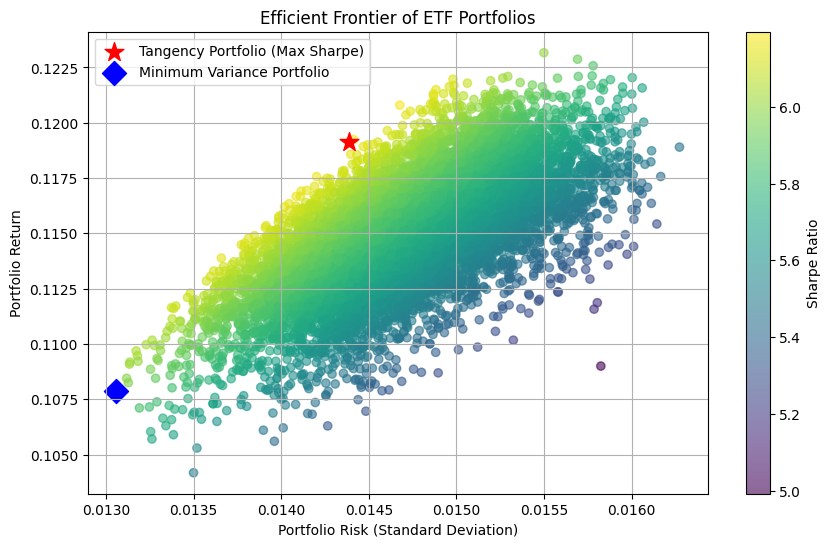

In [ ]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df["Portfolio Risk"], df["Portfolio Return"], c=df["Sharpe Ratio"], cmap='viridis', alpha=0.6)
plt.colorbar(label='Sharpe Ratio')

# Label axes
plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Portfolio Return')
plt.title('Efficient Frontier of ETF Portfolios')
plt.grid(True)

# Highlight the Tangency Portfolio (Max Sharpe Ratio)
plt.scatter(max_sharpe_portfolio["Portfolio Risk"], max_sharpe_portfolio["Portfolio Return"],
            color='red', marker='*', s=200, label='Tangency Portfolio (Max Sharpe)')

# Highlight the Minimum Variance Portfolio
plt.scatter(min_variance_portfolio["Portfolio Risk"], min_variance_portfolio["Portfolio Return"],
            color='blue', marker='D', s=150, label='Minimum Variance Portfolio')

# Add legend
plt.legend()
plt.show()

In [ ]:
print("🔴 Tangency Portfolio (Max Sharpe Ratio):")
print(max_sharpe_portfolio)

print("\n🔵 Minimum Variance Portfolio (Lowest Risk):")
print(min_variance_portfolio)

🔴 Tangency Portfolio (Max Sharpe Ratio):
Portfolio Return    0.119147
Portfolio Risk      0.014389
Sharpe Ratio        6.195563
SPYG                0.421688
VTV                 0.148995
VBK                 0.002459
VBR                 0.000487
IJH                 0.426371
Name: 7444, dtype: float64

🔵 Minimum Variance Portfolio (Lowest Risk):
Portfolio Return    0.107894
Portfolio Risk      0.013056
Sharpe Ratio        5.966082
SPYG                0.269396
VTV                 0.596455
VBK                 0.059364
VBR                 0.036725
IJH                 0.038060
Name: 2538, dtype: float64
